In [14]:
list.of.packages = c('rpart','caret','ggplot2','randomForest',
                     'tidyverse','ranger','e1071','rpart.plot')
new.packages = list.of.packages[!(list.of.packages 
                      %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages,
                        repos='http://cran.us.r-project.org')

options(warn=-1)
suppressWarnings(library(rpart, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(rpart.plot, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ranger, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(e1071, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(randomForest, quietly = TRUE, warn.conflicts = FALSE))


In this module we will re-examine the Housing data. 

However, instead of assuming the model is linear ($Y = X\beta + \varepsilon$) we will be agnostic about functional form.

Let $Y=g(X)+\varepsilon$. To estimate the unknown function $g(X)$, we will use Regression Trees and Forests.

In [13]:
Housing = read.csv('ahs_clean.csv')   
# Reads csv files into R

cat('Dataset dimesions: ',dim(Housing))                  
# Returns the dimension of the dataset             

Housing$LOGSQFT = log(Housing$UNITSF)
Housing$LOGLOT = log(Housing$LOT)

Housing[1:10,1:10]                                         
# Examine the first few rows and columns of our data                


Dataset dimesions:  51808 212

LOGVALUE,LOT,UNITSF,CLIMB,DIRAC,NUMAIR,BUSPER,EXCLUS,HOWH,NUMCOLD
13.48701,5900.00,3000,2.011952,1.51928,1.730885,0,0,8.000000,1.828194
13.21767,43925.93,1600,2.011952,1.51928,1.730885,0,0,9.000000,1.828194
13.48701,5900.00,2500,2.011952,1.51928,1.730885,0,0,8.555945,1.828194
13.01700,2000.00,1600,2.011952,1.51928,1.730885,1,0,9.000000,1.828194
13.45884,6000.00,2750,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
13.51441,5500.00,2350,2.011952,0.00000,1.730885,0,1,10.000000,1.828194
13.21767,6000.00,1901,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
14.07787,6500.00,5700,2.011952,1.51928,1.730885,0,0,10.000000,1.828194
14.22098,10000.00,5700,2.011952,1.00000,1.730885,0,1,10.000000,1.828194
11.54248,9000.00,2300,2.011952,1.51928,1.730885,0,0,10.000000,1.828194


Since we already examined this data, let's go ahead and use the larger model with 60 covariates.

In [3]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)          
    # Randomly choose the index for the splits
    data = data[random,]                      
    # Shuffle data
    test = data[1:round(N*split),]            
    # Splits
    train = data[(round(N*split)+1):N,]

    
    return(list(train,test))
}


tmp = data_split(Housing) 
train_test = tmp[[1]]
validation = tmp[[2]]

In [4]:
train1 = train_test[c('LOGVALUE','LOGLOT','LOGSQFT','BEDRMS','BATHS',
                      'REGION','METRO','KITCHEN','DISH','WASH','DRY',
                      'COOK','DENS','DINING','FAMRM','HALFB','LIVING',
                      'OTHFN','RECRM','PORCH','SINK','LAUNDY','FLOORS',
                      'CONDO','ROOMS','PLUMB','NOWIRE','AGE')]

train1 = cbind(train1,select(train_test,starts_with('Roach')),
               select(train_test,starts_with('Rats')),
              select(train_test,starts_with('Water')),
               select(train_test,starts_with('Cellar')),
               select(train_test,starts_with('Num')),
               select(train_test,starts_with('Freeze')))


val1 = validation[colnames(train1)]


In the MSE case the regression tree will predict: 

$\hat{c}_m = \frac{\sum_i y_i 1(x\in R_m)}{\sum_i 1(x\in R_m)}$, which is nothing more than the average outcome given the covariate values in the region.


When fitting a regression tree one needs to decide how to generate the splits that make up the tree. Further one needs to decide how deep to make the tree. There are different data-driven approaches to making these selections. In this module we will choose the model based on the complexity:

$C_\alpha(T) = \sum_m N_m Q_m(T) + \alpha |T|$

$N_m$ is the number of observations in node $m$

$|T|$ is the number of terminal nodes in tree T

$Q_m(T)=\frac{1}{N_m} \sum_{i:x_i\in R_m} (y_i-\hat{c}_m)^2$

Instead of manually choosing the depth of our tree, we will use Carat to tune the penalty $\alpha$.

In [5]:
model <- train(
  LOGVALUE ~.,data = train1,               
    # formula for the model
  method = "rpart",                           
    # Regression Trees
  trControl = trainControl(
    method = "cv", 
    number = 5,             
      # 5 fold cross-validatoin
  )
)

model$results

cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
0.03183627,0.9741609,0.17336979,0.6143909,0.01742652,0.024558019,0.008451061
0.06597948,0.9986146,0.13124228,0.6381598,0.02226196,0.033147736,0.026769000
0.09747511,1.0414115,0.09152347,0.6792751,0.03000983,0.002061573,0.031519464


The penalty parameter $\alpha$ chosen in this case is $\approx 0.032$.

In [6]:
formula = as.formula(paste("LOGVALUE~",
            paste(colnames(train1)[1:dim(train1)[2]],collapse="+")))

fit_tree = rpart(formula,data=train1, control=c(cp=model$bestTune))

We can visualize and interpret the regression tree with the following plot

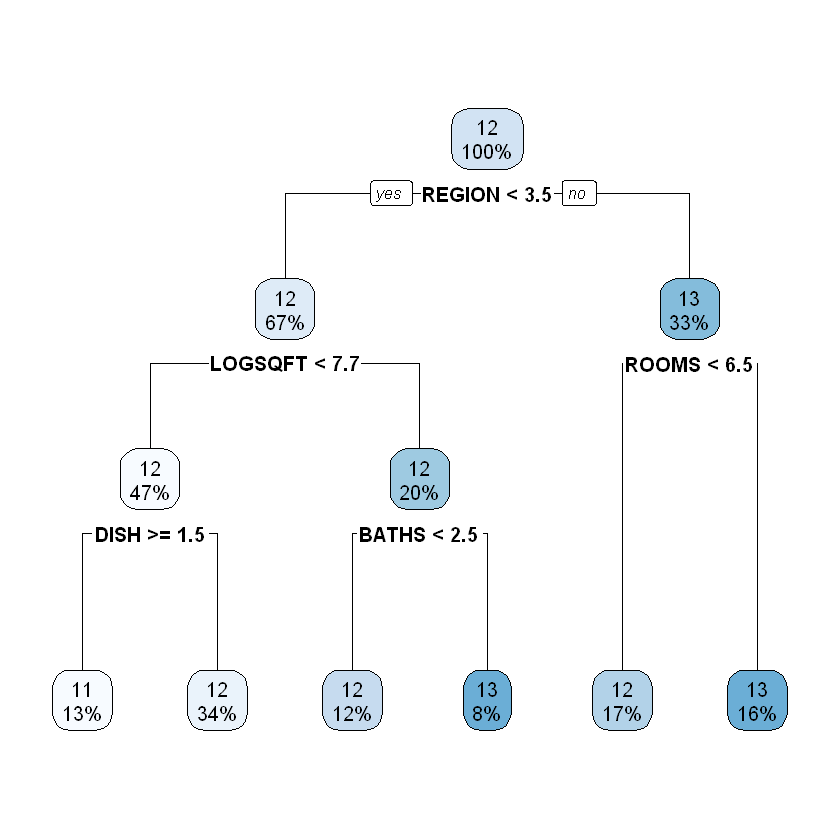

In [7]:
rpart.plot(fit_tree)

We see predicted (rounded) values for this tree above the frequency of those predictions. Let's see how we do on the validation set with this model.

In [8]:
yhat = predict(fit_tree,val1)
rmse = sqrt(mean((val1$LOGVALUE-yhat)^2))
cat('\nTree RMSE: ', rmse)


Tree RMSE:  1.086604

Trees are great for interpretation, but not the best for actual prediction. The RMSE we got is worse than the linear models we estimated in the previous module.

One idea that is common in machine learning is to combine weak learners together and produce an ensemble. When one does this with trees the method is known as random forests.

The basic idea is combine many shallow trees with only a subset of the covariates and average the predictions. Let's try it out!

In [9]:
rf_grid = expand.grid(mtry = c(5, 10, 15), 
          splitrule = c("variance"), min.node.size=c(5))
fit_forest = train(formula,
                   data = train1, 
                   method = 'ranger',
                   trControl = 
                   trainControl(method = 'cv',
                                number = 5),
                   tuneGrid = rf_grid, 
                   num.trees=10
                  )

In [10]:
fit_forest$results

mtry,splitrule,min.node.size,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
5,variance,5,0.8416696,0.3840645,0.5010820,0.03172367,0.01575172,0.007301056
10,variance,5,0.8429754,0.3818747,0.4989303,0.02899679,0.01553277,0.006370934
15,variance,5,0.8431393,0.3833763,0.5003073,0.03158785,0.02073955,0.007543335


Even with only 10 trees the results are improved!

EXERCISE:

Grow forests with 100 trees and use caret to tune the maximum number of covariates. Do your results improve?